# Machine Learning

Após discutir e decidir qual tema abordaríamos, o escolhido foi uma ideia abordando regressão onde :

- **Problema:** Prever o preço das passagens aéreas com base em diversos fatores.
- **Objetivo:** Auxiliar companhias aéreas e consumidores a entenderem a dinâmica dos preços e a tomarem decisões informadas sobre compra e venda de passagens.

Na abordagem utilizada, procuramos no site [Kaggle](https://www.kaggle.com/) e encontramos dados de reserva de voos da empresa [EaseMyTrip](https://www.easemytrip.com/) onde ela é uma empresa indiana multinacional de viagens online, sediada em Nova Déli, Índia. A empresa fornece reservas de hotéis, passagens aéreas, pacotes de férias nacionais e internacionais, reservas de ônibus e serviços de marca branca (produtos de preço mais económico e de qualidade relativamente baixa).

O tipo de aprendizado escolhido foi o *Supervisionado*.

Em relação as métricas escolhidas foram:
- **MAE e RMSE:** Avaliam a precisão das previsões em termos de magnitude do erro.
- **R²:** Mede o quão bem o modelo explica a variabilidade dos dados.

# Exploração

## Carregar e entender

A exploração inicial serve para entender a estrutura do conjunto de dados. Verificamos as primeiras linhas para ter uma ideia geral e utilizamos funções como `info()` para visualizar os tipos de dados e a presença de valores ausentes. Já a função `describe()` fornece estatísticas descritivas básicas, como média, mediana e desvio padrão para colunas numéricas e contagem de valores únicos para categóricas. Além disso as bibliotecas importantes para essa parte de exploração dos dados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
import os

# Carregar o dataset enviado pelo usuário
df = pd.read_csv(r'C:\Users\elyss\OneDrive\Área de Trabalho\Machine_Learning\Flight_Prediction\Dados\Clean_Dataset.csv')

# Exibir as primeiras linhas do dataset para análise inicial
print(df.info())
print('-/-'*50)
print(df.describe())
print('-/-'*50)
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB
None
-/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/

- airline: Nome da companhia aérea.
- flight: Código do voo.
- source_city: Cidade de origem.
- departure_time: Período do horário de partida.
- stops: Número de paradas.
- arrival_time: Período do horário de chegada.
- destination_city: Cidade de destino.
- class: Classe do assento (Economy ou Business).
- duration: Duração da viagem em horas.
- days_left: Dias restantes até o voo.
- price: Variável-alvo representando o preço da passagem.

**O dataset parece estruturado e pronto para análise inicial.**

- A coluna "Unnamed: 0" parece ser um índice gerado automaticamente e pode ser removida.
- A variável-alvo "price" é contínua e adequada para o modelo de regressão linear.

Criamos uma cópia para iniciar a exploração e preparação do dataset e removemos a coluna Unmamed:0 do dataset de exploração, deixando o original, intacto.

In [2]:
# Cópia do dataset original
df_exploracao = df.copy()

# Função para verificar a existência de uma coluna em um DataFrame
def verificar_coluna(df, coluna):
    if coluna in df.columns:
        print(f"A coluna '{coluna}' existe no DataFrame.")
        # Drop da coluna 'Unnamed: 0' e foi a única operação de limpeza realizada
        df_exploracao.drop('Unnamed: 0', axis=1, inplace=True)
    else:
        print(f"A coluna '{coluna}' não existe no DataFrame.")

# Verificar a existência da coluna 'Unnamed: 0' no DataFrame df_exploracao
verificar_coluna(df_exploracao, 'Unnamed: 0')

A coluna 'Unnamed: 0' existe no DataFrame.


## Verificando os atributos, Visualizações e Correlações

- Avaliamos o tipo de dado: categórico,
numérico ou texto.
- Identificamos a porcentagem de valores ausentes e verificamos a presença de ruídos, como outliers ou erros de arredondamento.
- Analisamos a utilidade de cada atributo para a tarefa, distinguindo quais variáveis são mais relevantes.
- Verificamos a distribuição (gaussiana, uniforme, etc.) das variáveis numéricas, o que é essencial para determinar a necessidade de transformações futuras.
- Histogramas ajudam a visualizar distribuições.
- Matriz de correlação identifica relações lineares entre variáveis numéricas, destacando potenciais redundâncias.
- Diagramas de dispersão (scatter plots) permitem analisar associações específicas.
- A visualização é crucial para identificar padrões que podem ser úteis na modelagem e para decidir quais atributos precisam de mais atenção.


Nessa etapa buscamos entender os atributos que estamos enfrentando.

In [3]:
# Nome dos atributos
atributos = df_exploracao.columns

# Tipo dos atributos
tipos = df_exploracao.dtypes

# % de valores ausentes
valores_ausentes = df_exploracao.isnull().mean() * 100

# Estatísticas descritivas para identificar possíveis ruídos
estatisticas = df_exploracao.describe(include='all')

valores_ausentes, estatisticas

(airline             0.0
 flight              0.0
 source_city         0.0
 departure_time      0.0
 stops               0.0
 arrival_time        0.0
 destination_city    0.0
 class               0.0
 duration            0.0
 days_left           0.0
 price               0.0
 dtype: float64,
         airline  flight source_city departure_time   stops arrival_time  \
 count    300153  300153      300153         300153  300153       300153   
 unique        6    1561           6              6       3            6   
 top     Vistara  UK-706       Delhi        Morning     one        Night   
 freq     127859    3235       61343          71146  250863        91538   
 mean        NaN     NaN         NaN            NaN     NaN          NaN   
 std         NaN     NaN         NaN            NaN     NaN          NaN   
 min         NaN     NaN         NaN            NaN     NaN          NaN   
 25%         NaN     NaN         NaN            NaN     NaN          NaN   
 50%         NaN     NaN

- Estatísticas Descritivas:

  - Duração (duration): Varia de 0.83 a 49.83 horas, com uma média de ~12.22 horas.
  - Dias restantes (days_left): Variam de 1 a 49, com uma média de ~26 dias.
  - Preço (price): Varia de ₹1,105 a ₹123,071, com uma mediana de ₹7,425 e uma média de ~₹20,890.
- Valores Ausentes:
  - Nenhuma coluna apresenta valores ausentes, indicando que os dados estão completos.
- Outliers:
  - O preço apresenta uma alta amplitude (máximo de ₹123,071), sugerindo a presença de outliers ou uma distribuição enviesada.

as saídas foram interessantes, interpretando a saída do atributo price : 

- count: 300153.000000
    - O número total de entradas na coluna price é 300153.
- unique: NaN
    - Não aplicável para colunas numéricas, por isso está como NaN.
- top: NaN
    - Não aplicável para colunas numéricas, por isso está como NaN.
- freq: NaN
    - Não aplicável para colunas numéricas, por isso está como NaN.
- mean: 20889.660523
    - A média dos valores na coluna price é aproximadamente 20889.66.
- std: 22697.767366
    - O desvio padrão dos valores na coluna price é aproximadamente 22697.77, indicando a dispersão dos valores em torno da média.
- min: 1105.000000
    - O valor mínimo na coluna price é 1105.
- 25%: 4783.000000
    - O primeiro quartil (25%) dos valores na coluna price é 4783, o que significa que 25% dos valores são menores ou iguais a 4783.
- 50%: 7425.000000
    - O valor mediano (50%) na coluna price é 7425, o que significa que metade dos valores são menores ou iguais a 7425.
- 75%: 42521.000000
    - O terceiro quartil (75%) dos valores na coluna price é 42521, o que significa que 75% dos valores são menores ou iguais a 42521.
- max: 123071.000000
    - O valor máximo na coluna price é 123071.

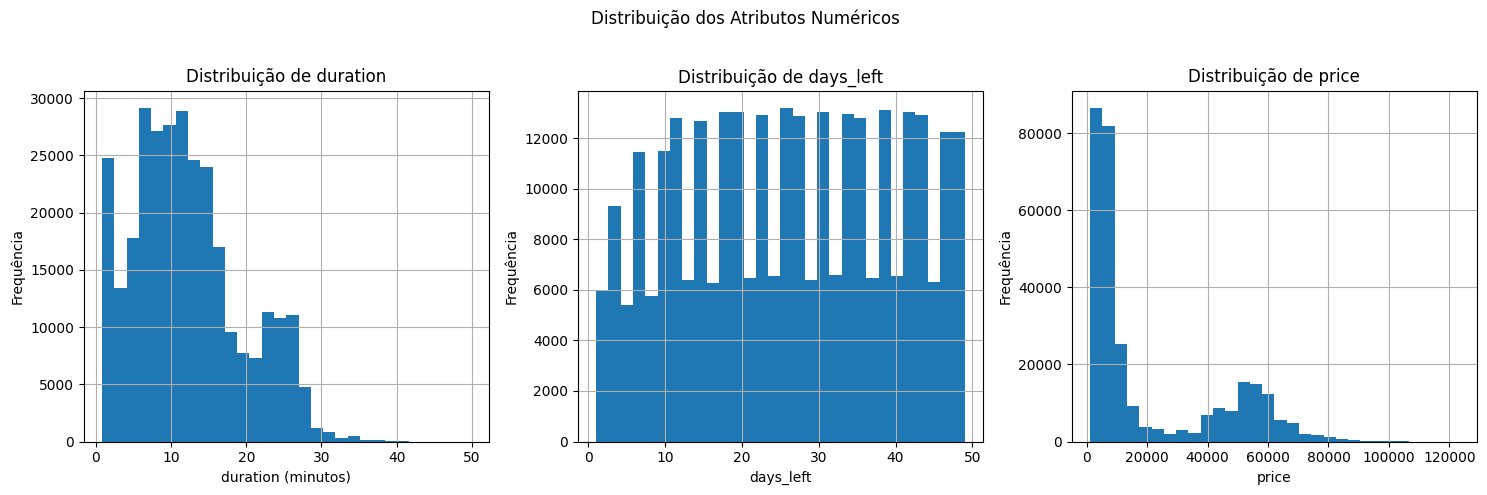

In [4]:
# Selecionar apenas as colunas numéricas relevantes
df_numerico = df_exploracao[['duration', 'days_left', 'price']]

# Visualizar a distribuição dos dados para cada atributo numérico
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_numerico['duration'].hist(bins=30, ax=axes[0])
axes[0].set_title('Distribuição de duration')
axes[0].set_xlabel('duration (minutos)')
axes[0].set_ylabel('Frequência')

df_numerico['days_left'].hist(bins=30, ax=axes[1])
axes[1].set_title('Distribuição de days_left')
axes[1].set_xlabel('days_left')
axes[1].set_ylabel('Frequência')

df_numerico['price'].hist(bins=30, ax=axes[2])
axes[2].set_title('Distribuição de price')
axes[2].set_xlabel('price')
axes[2].set_ylabel('Frequência')

plt.suptitle('Distribuição dos Atributos Numéricos')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Embora a média esteja em torno de 20000, podemos ver aqui que a mediana é de aproximadamente 7500. Essa diferença é explicável pela presença de dois tickets diferentes: executiva e econômica. No segundo gráfico, podemos ver que a dispersão parece ser composta por duas curvas gaussianas.

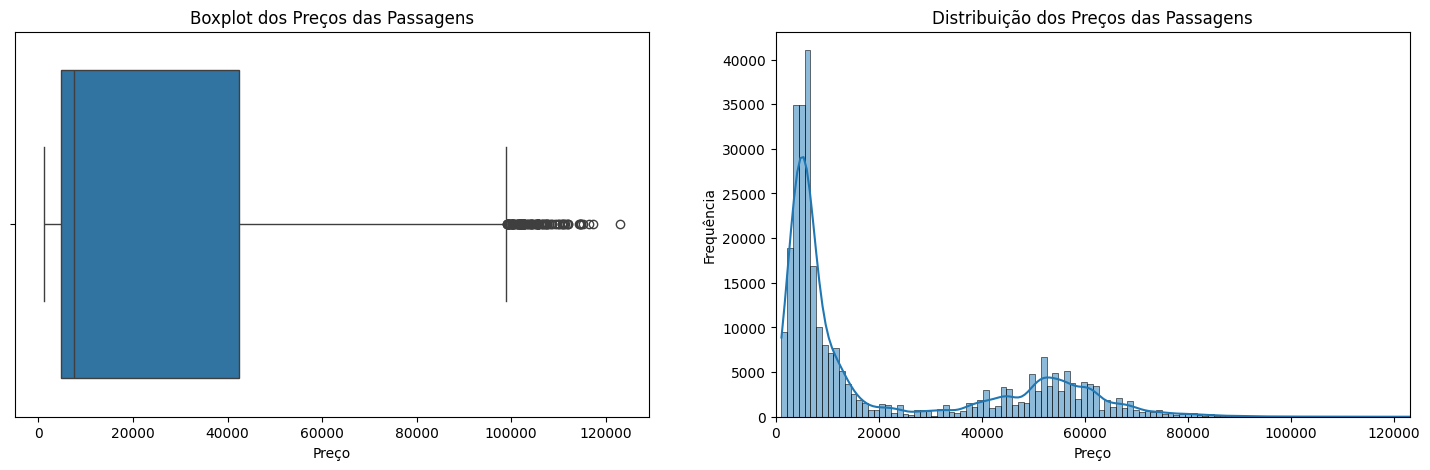

In [5]:
# Analisar a distribuição da coluna 'price'
plt.figure(figsize = (18,5))
plt.subplot(1,2,2)
sns.histplot(df_exploracao['price'], kde=True)
plt.title('Distribuição dos Preços das Passagens')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.xlim(0, df_exploracao['price'].max())

plt.subplot(1,2,1)
sns.boxplot(x = 'price', data = df_exploracao)
plt.title('Boxplot dos Preços das Passagens')
plt.xlabel('Preço')
plt.show()

em seguida pensamos em ter uma ideia de quais companhias aéreas estão presentes e sua quantidade de voos, agrupamos para melhor visualizar, no dataset como um todo

In [6]:
# Agrupamento de voos por companhia aérea
df1=df_exploracao.groupby(['flight','airline'],as_index=False).count()
df1.airline.value_counts()

airline
Indigo       704
Air_India    218
GO_FIRST     205
SpiceJet     186
Vistara      133
AirAsia      115
Name: count, dtype: int64

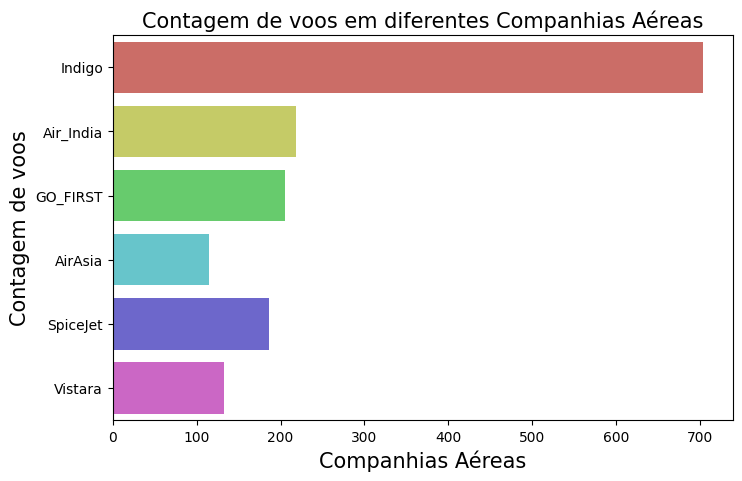

In [7]:
plt.figure(figsize=(8,5))
sns.countplot(df1['airline'],palette='hls')
plt.title('Contagem de voos em diferentes Companhias Aéreas',fontsize=15)
plt.xlabel('Companhias Aéreas',fontsize=15)
plt.ylabel('Contagem de voos',fontsize=15)
plt.show()

é percetível a grande quantidade de ocorrência em **Indigo**.

Text(0.5, 1.0, 'Preços das Companhias aéreas com a classe do voo')

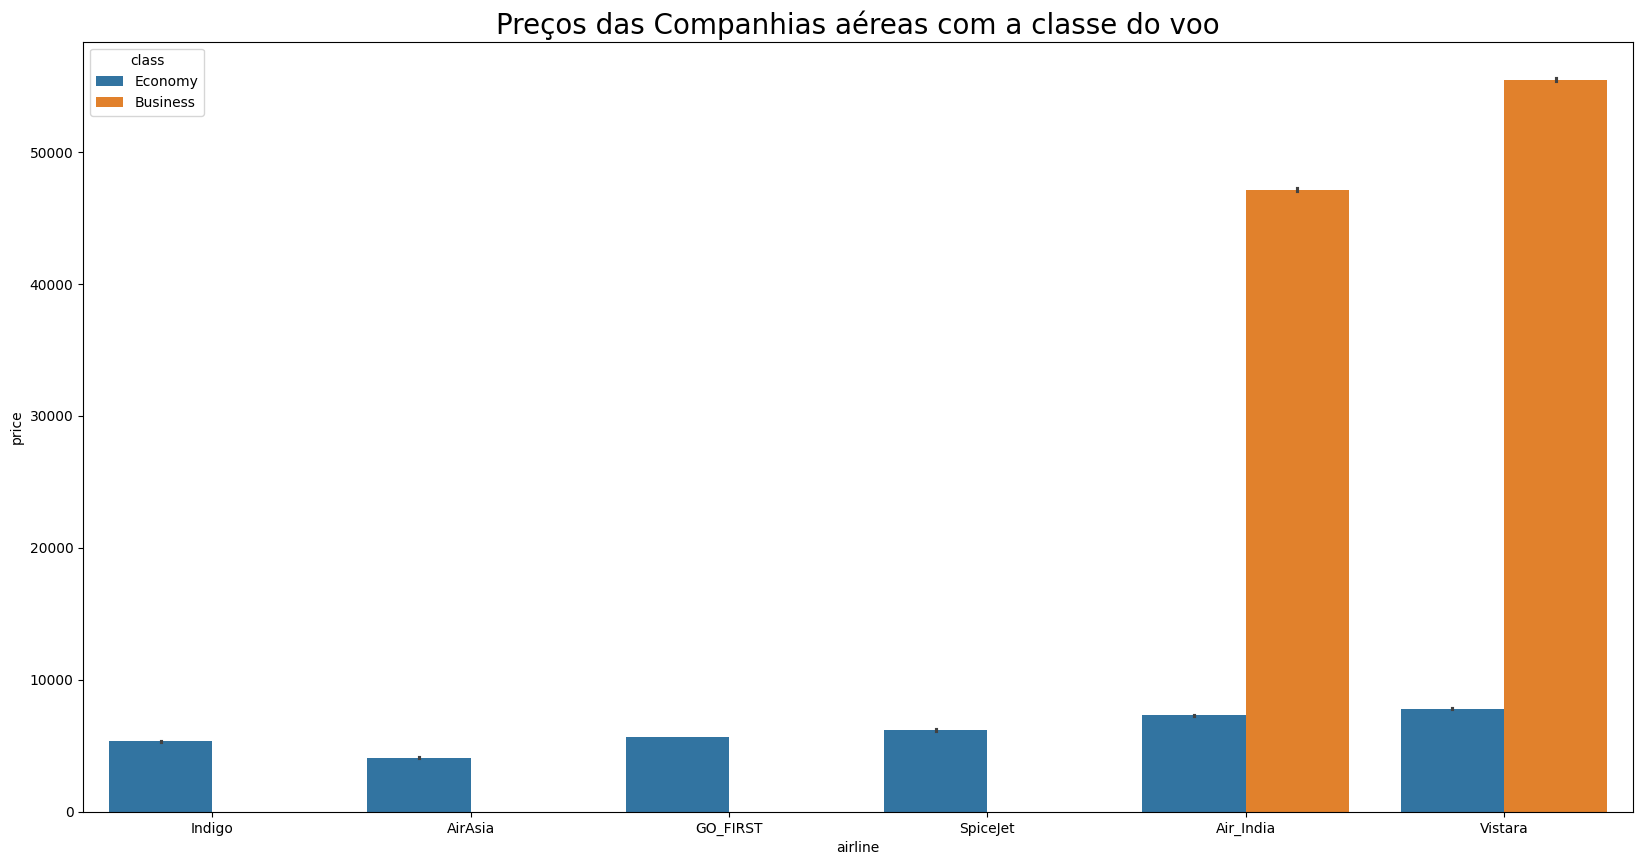

In [8]:
plt.figure(figsize=(20, 10))
sns.barplot(x='airline',y='price',hue="class",data=df_exploracao.sort_values("price")).set_title('Preços das Companhias aéreas com a classe do voo',fontsize=20)

depois, buscamos entender as classificações dos tipos de voos que temos, agrupando e trazendo a sua contagem de ocorrências

In [9]:
# Agrupamento do tipo de companhia e a classe do voo
df2=df_exploracao.groupby(['flight','airline','class'],as_index=False).count()
df2['class'].value_counts()

class
Economy     1560
Business     295
Name: count, dtype: int64

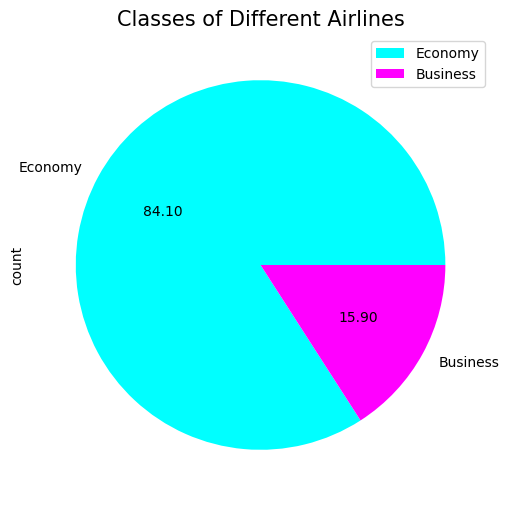

In [10]:
plt.figure(figsize=(8,6))
df2['class'].value_counts().plot(kind='pie',textprops={'color':'black'},autopct='%.2f',cmap='cool')
plt.title('Classes of Different Airlines',fontsize=15)
plt.legend(['Economy','Business'])
plt.show()

*O preço varia com as companhias aéreas?*

- Como podemos ver, a Vistara tem a faixa de preço máxima
- A Vistara e a Air_India Airlines têm o preço máximo quando comparadas a outras
- A SpiceJet, a AirAsia, a GO_First e a Indigo têm preços um tanto quanto iguais

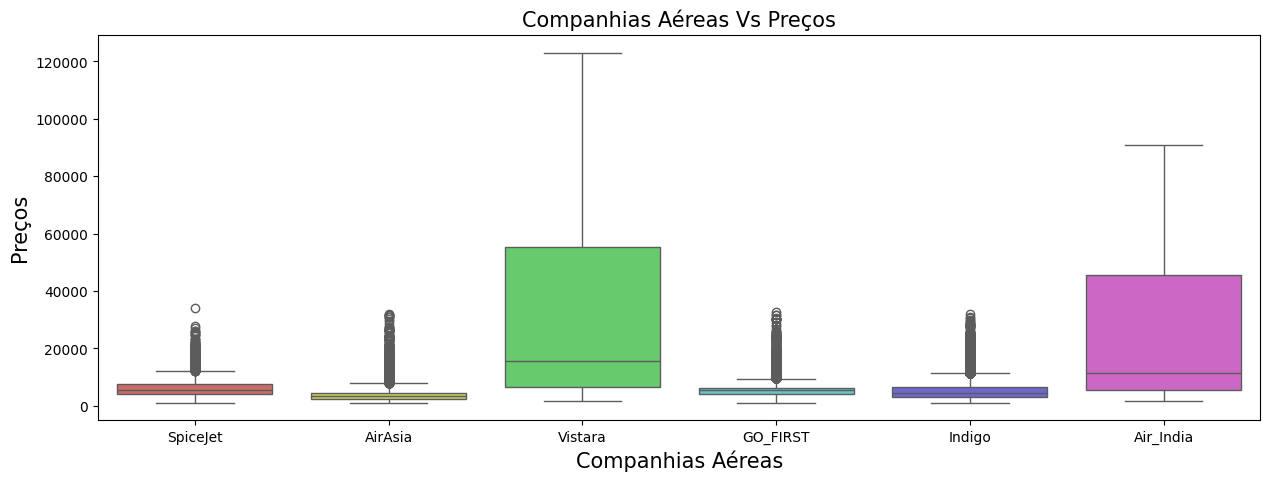

In [11]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df['airline'],y=df['price'],palette='hls')
plt.title('Companhias Aéreas Vs Preços',fontsize=15)
plt.xlabel('Companhias Aéreas',fontsize=15)
plt.ylabel('Preços',fontsize=15)
plt.show()

*Variação entre o preço da passagem, varia entre as classes?*

- O preço do bilhete é máximo para a classe executiva quando comparado à classe econômica

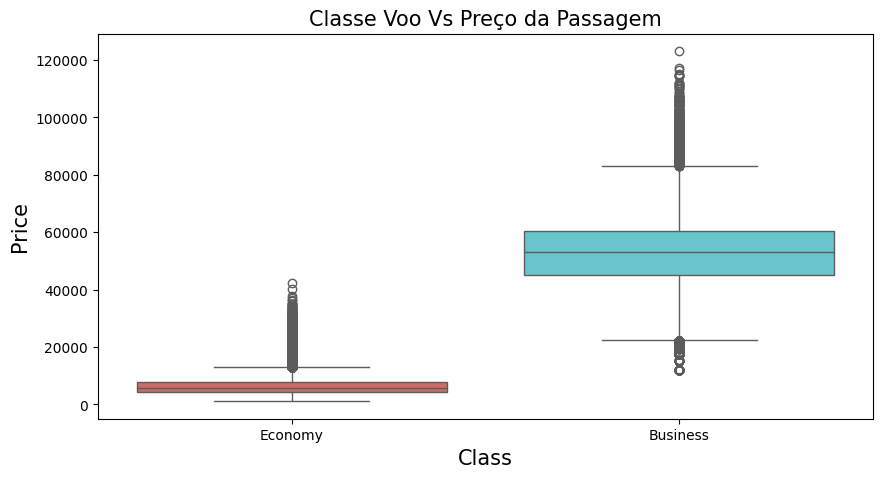

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(x='class',y='price',data=df,palette='hls')
plt.title('Classe Voo Vs Preço da Passagem',fontsize=15)
plt.xlabel('Class',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

*Como o preço do bilhete varia com o número de paradas de um voo?*

- Voos com uma parada têm preço máximo de bilhete

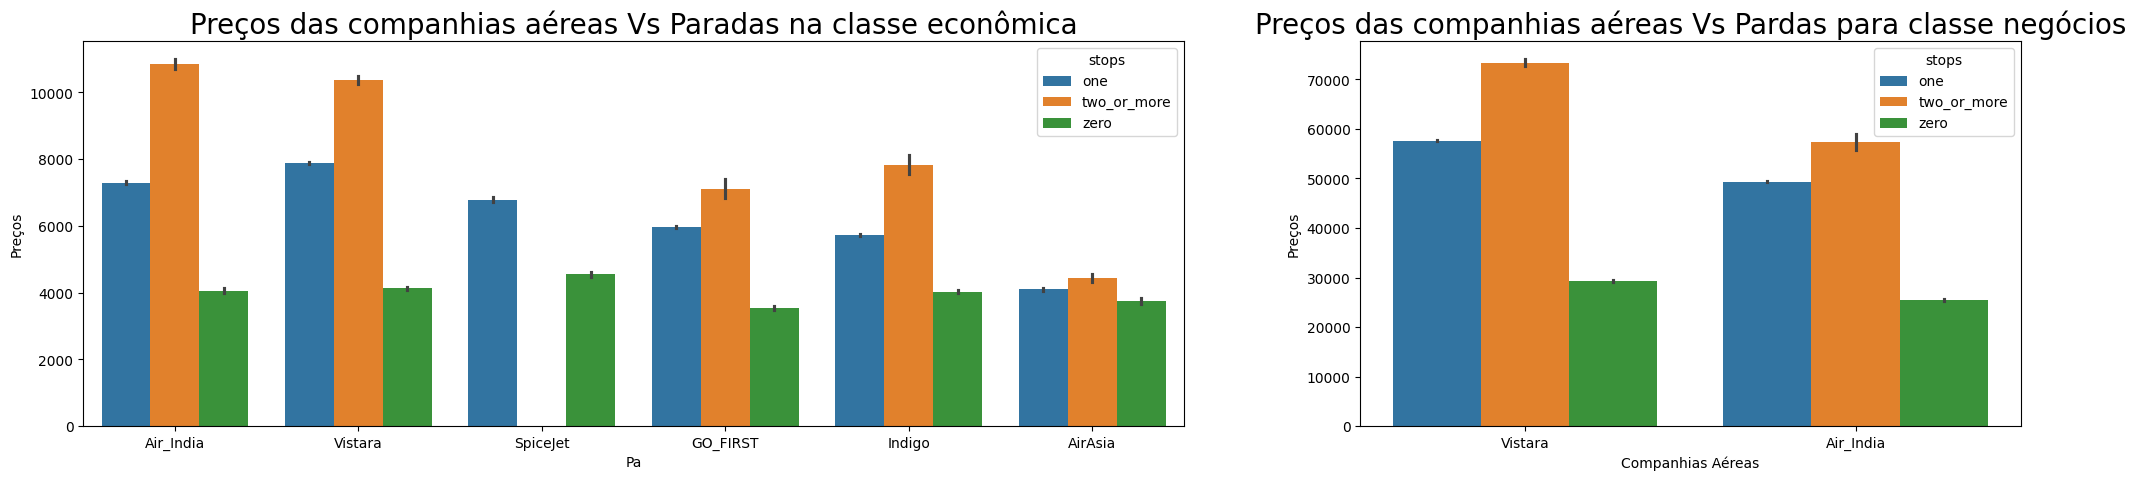

In [13]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))

sns.barplot(y="price", x="airline", hue="stops", data=df_exploracao.loc[df_exploracao["class"] == 'Economy'].sort_values("price", ascending=False), ax=axs[0])
axs[0].set_title("Preços das companhias aéreas Vs Paradas na classe econômica", fontsize=20)
axs[0].set_xlabel("Pa")
axs[0].set_ylabel("Preços")

sns.barplot(y="price", x="airline", hue="stops", data=df_exploracao.loc[df_exploracao["class"] == 'Business'].sort_values("price", ascending=False), ax=axs[1])
axs[1].set_title("Preços das companhias aéreas Vs Pardas para classe negócios", fontsize=20)
axs[1].set_xlabel("Companhias Aéreas")
axs[1].set_ylabel("Preços")

plt.show()

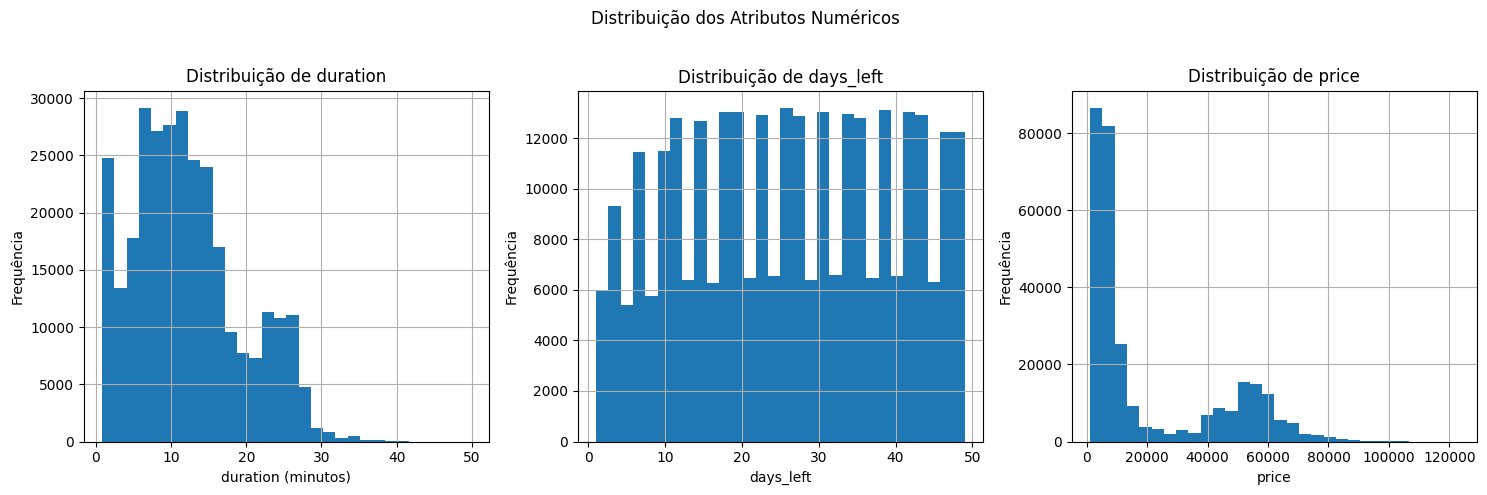

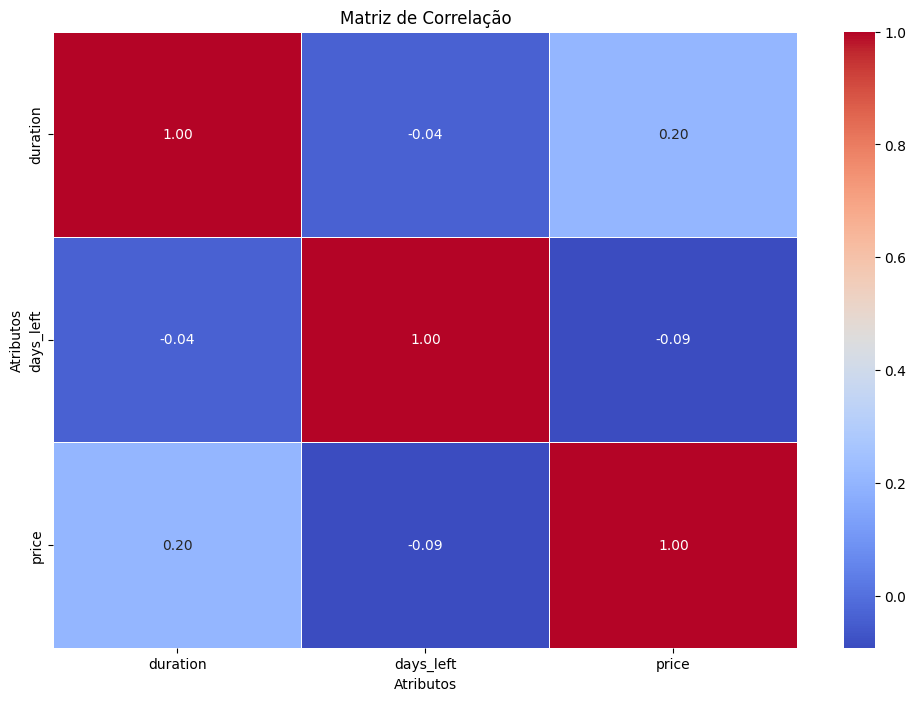

Pares de atributos com alta correlação:
           duration  days_left  price
duration        1.0        NaN    NaN
days_left       NaN        1.0    NaN
price           NaN        NaN    1.0


In [14]:
# Selecionar apenas as colunas numéricas relevantes
df_numerico = df_exploracao[['duration', 'days_left', 'price']]

# Visualizar a distribuição dos dados para cada atributo numérico
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_numerico['duration'].hist(bins=30, ax=axes[0])
axes[0].set_title('Distribuição de duration')
axes[0].set_xlabel('duration (minutos)')
axes[0].set_ylabel('Frequência')

df_numerico['days_left'].hist(bins=30, ax=axes[1])
axes[1].set_title('Distribuição de days_left')
axes[1].set_xlabel('days_left')
axes[1].set_ylabel('Frequência')

df_numerico['price'].hist(bins=30, ax=axes[2])
axes[2].set_title('Distribuição de price')
axes[2].set_xlabel('price')
axes[2].set_ylabel('Frequência')

plt.suptitle('Distribuição dos Atributos Numéricos')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Visualizar a correlação entre os atributos numéricos
correlacao = df_numerico.corr()
plt.figure(figsize=(12, 8))
plt.title('Matriz de Correlação')
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.xlabel('Atributos')
plt.ylabel('Atributos')
plt.show()

# Identificar pares de atributos com alta correlação (acima de 0.8 ou abaixo de -0.8)
alta_correlacao = correlacao[(correlacao > 0.8) | (correlacao < -0.8)]
print("Pares de atributos com alta correlação:")
print(alta_correlacao)

*O preço varia com as companhias aéreas?*

- Como podemos ver, a Vistara tem a faixa de preço máxima
- A Vistara e a Air_India Airlines têm o preço máximo quando comparadas a outras
- A SpiceJet, a AirAsia, a GO_First e a Indigo têm preços um tanto quanto iguais

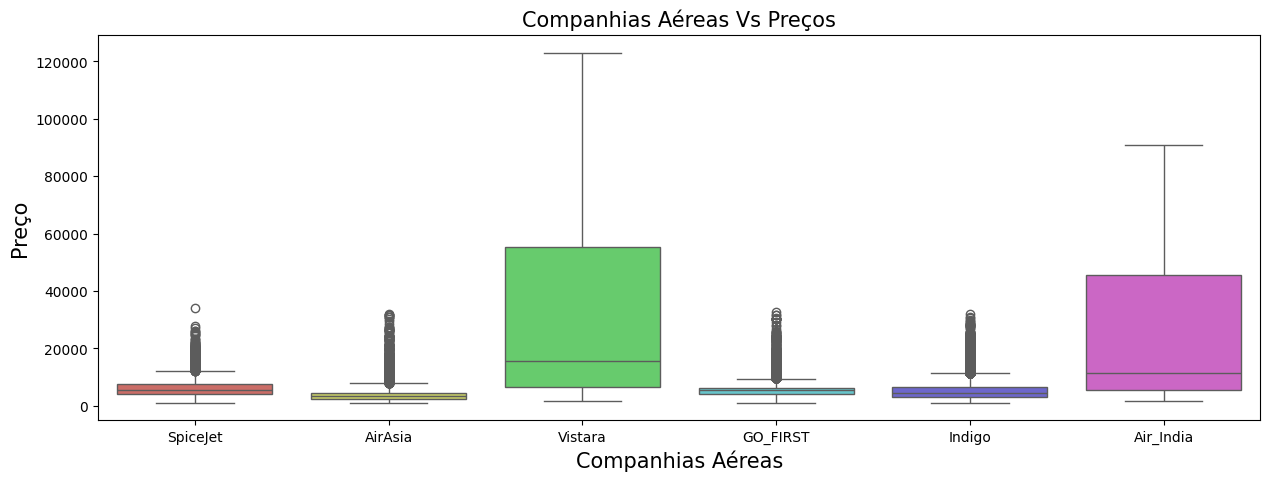

In [15]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df_exploracao['airline'],y=df_exploracao['price'],palette='hls')
plt.title('Companhias Aéreas Vs Preços',fontsize=15)
plt.xlabel('Companhias Aéreas',fontsize=15)
plt.ylabel('Preço',fontsize=15)
plt.show()

*Como o preço do bilhete varia com o número de paradas de um voo?*

- Voos com uma parada têm preço máximo de bilhete

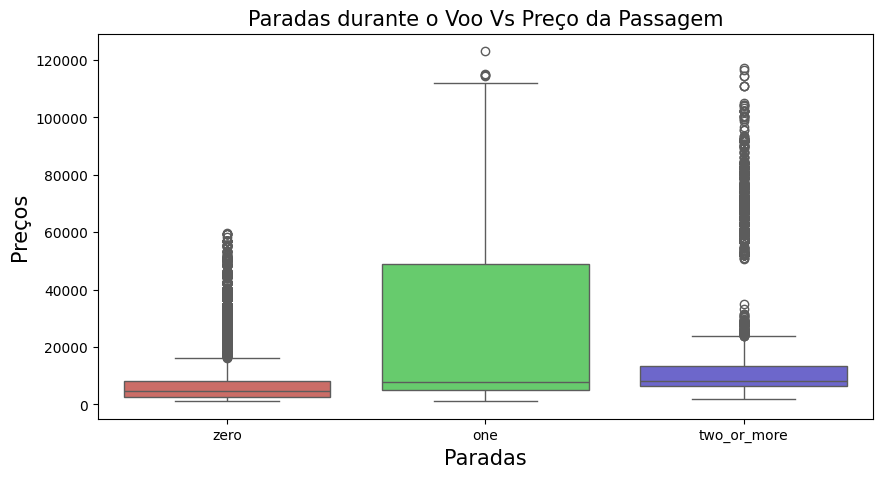

In [16]:
plt.figure(figsize=(10,5))
sns.boxplot(x='stops',y='price',data=df_exploracao,palette='hls')
plt.title('Paradas durante o Voo Vs Preço da Passagem',fontsize=15)
plt.xlabel('Paradas',fontsize=15)
plt.ylabel('Preços',fontsize=15)
plt.show()

*Número total de voos de uma cidade para outra*

In [17]:
# Agrupa os voos por cidade de origem e destino
grouped_df = df_exploracao.groupby(['flight','source_city','destination_city','airline','class'], as_index=False).count()
# Agrupa os voos por cidade de origem e destino e conta o número de voos
result = grouped_df.groupby(['source_city','destination_city'], as_index=False)['flight'].count().head(10)
print(result)

  source_city destination_city  flight
0   Bangalore          Chennai     106
1   Bangalore            Delhi     227
2   Bangalore        Hyderabad     132
3   Bangalore          Kolkata     171
4   Bangalore           Mumbai     175
5     Chennai        Bangalore      69
6     Chennai            Delhi     105
7     Chennai        Hyderabad      82
8     Chennai          Kolkata     110
9     Chennai           Mumbai      94


*Preço médio de diferentes companhias aéreas da cidade de origem para a cidade de destino*

In [18]:
# Agrupa os voos por cidade de origem e destino e calcula a média dos preços
df_exploracao.groupby(['airline','source_city','destination_city'],as_index=False)['price'].mean().head(10)

,airline,source_city,destination_city,price
0,AirAsia,Bangalore,Chennai,2073.043478
1,AirAsia,Bangalore,Delhi,4807.092426
2,AirAsia,Bangalore,Hyderabad,2931.494792
3,AirAsia,Bangalore,Kolkata,4443.468160
4,AirAsia,Bangalore,Mumbai,3342.385350
5,AirAsia,Chennai,Bangalore,1914.760870
6,AirAsia,Chennai,Delhi,3697.314003
7,AirAsia,Chennai,Hyderabad,2053.182540
8,AirAsia,Chennai,Kolkata,3682.338762
9,AirAsia,Chennai,Mumbai,2691.100000


*Como o preço varia com a duração do voo com base na classe?*

- Com o aumento da duração, o preço da passagem também aumenta nas classes Economy e Business

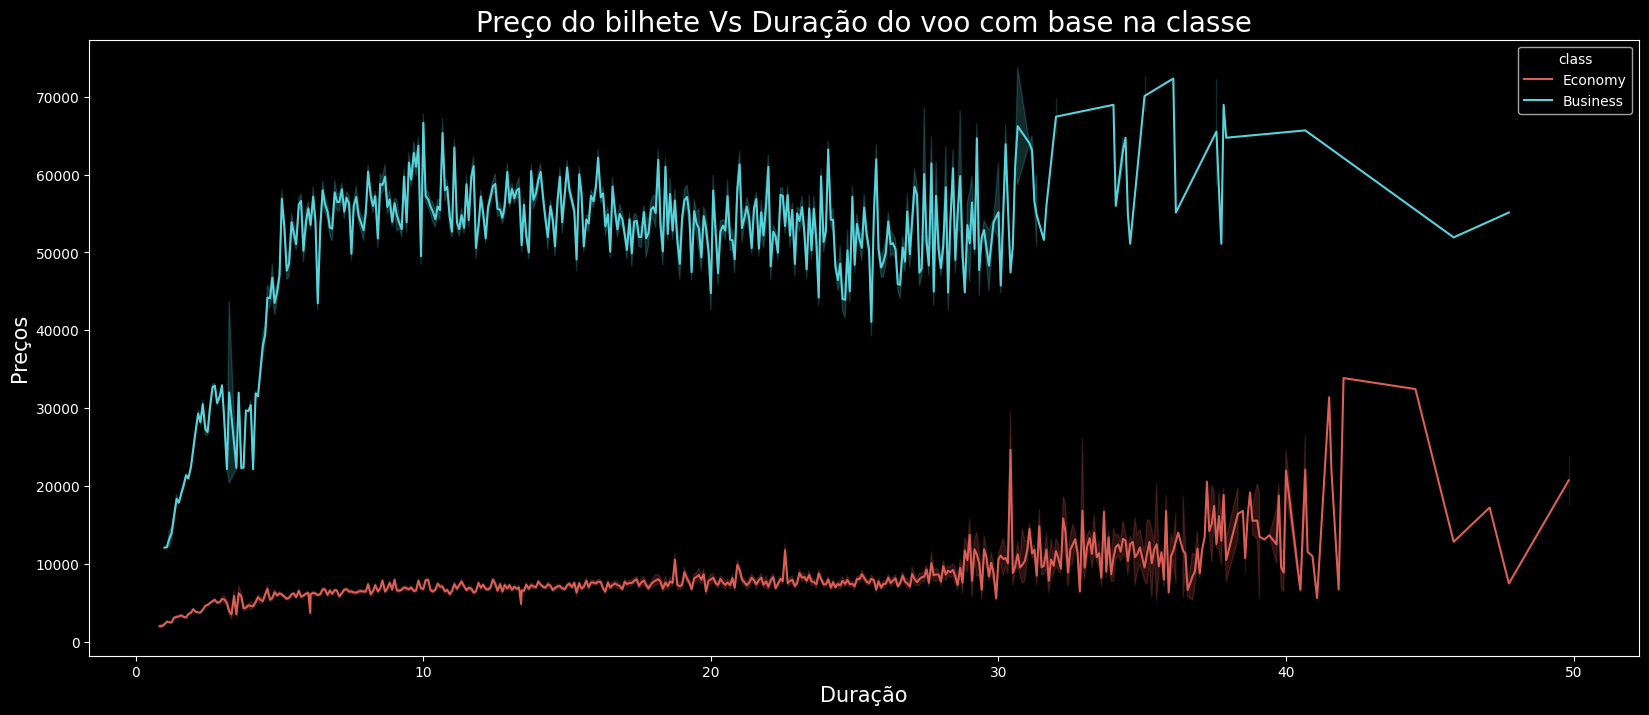

In [19]:
plt.style.use('dark_background')
plt.figure(figsize=(20,8))
sns.lineplot(data=df_exploracao,x='duration',y='price',hue='class',palette='hls')
plt.title('Preço do bilhete Vs Duração do voo com base na classe',fontsize=20)
plt.xlabel('Duração',fontsize=15)
plt.ylabel('Preços',fontsize=15)
plt.show()

*Como o preço muda com a mudança na cidade de origem e na cidade de destino?*
1. Cidade de origem x preço do bilhete

- O preço do bilhete é maior para os voos cuja cidade de origem é Calcutá
- O preço do bilhete é quase igual para voos com cidades de origem como Mumbai e Chennai, Hyderabad e Bangalore
- O preço do bilhete é menor para voos com cidade de origem como Déli
2. Cidade de destino x preço do bilhete
- O preço do bilhete é maior para voos cuja cidade de destino é Calcutá e Chennai
- O preço do bilhete é quase igual para voos com cidades de destino como Mumbai e Bangalore
- O preço do bilhete é menor para voos com cidade de destino como Déli

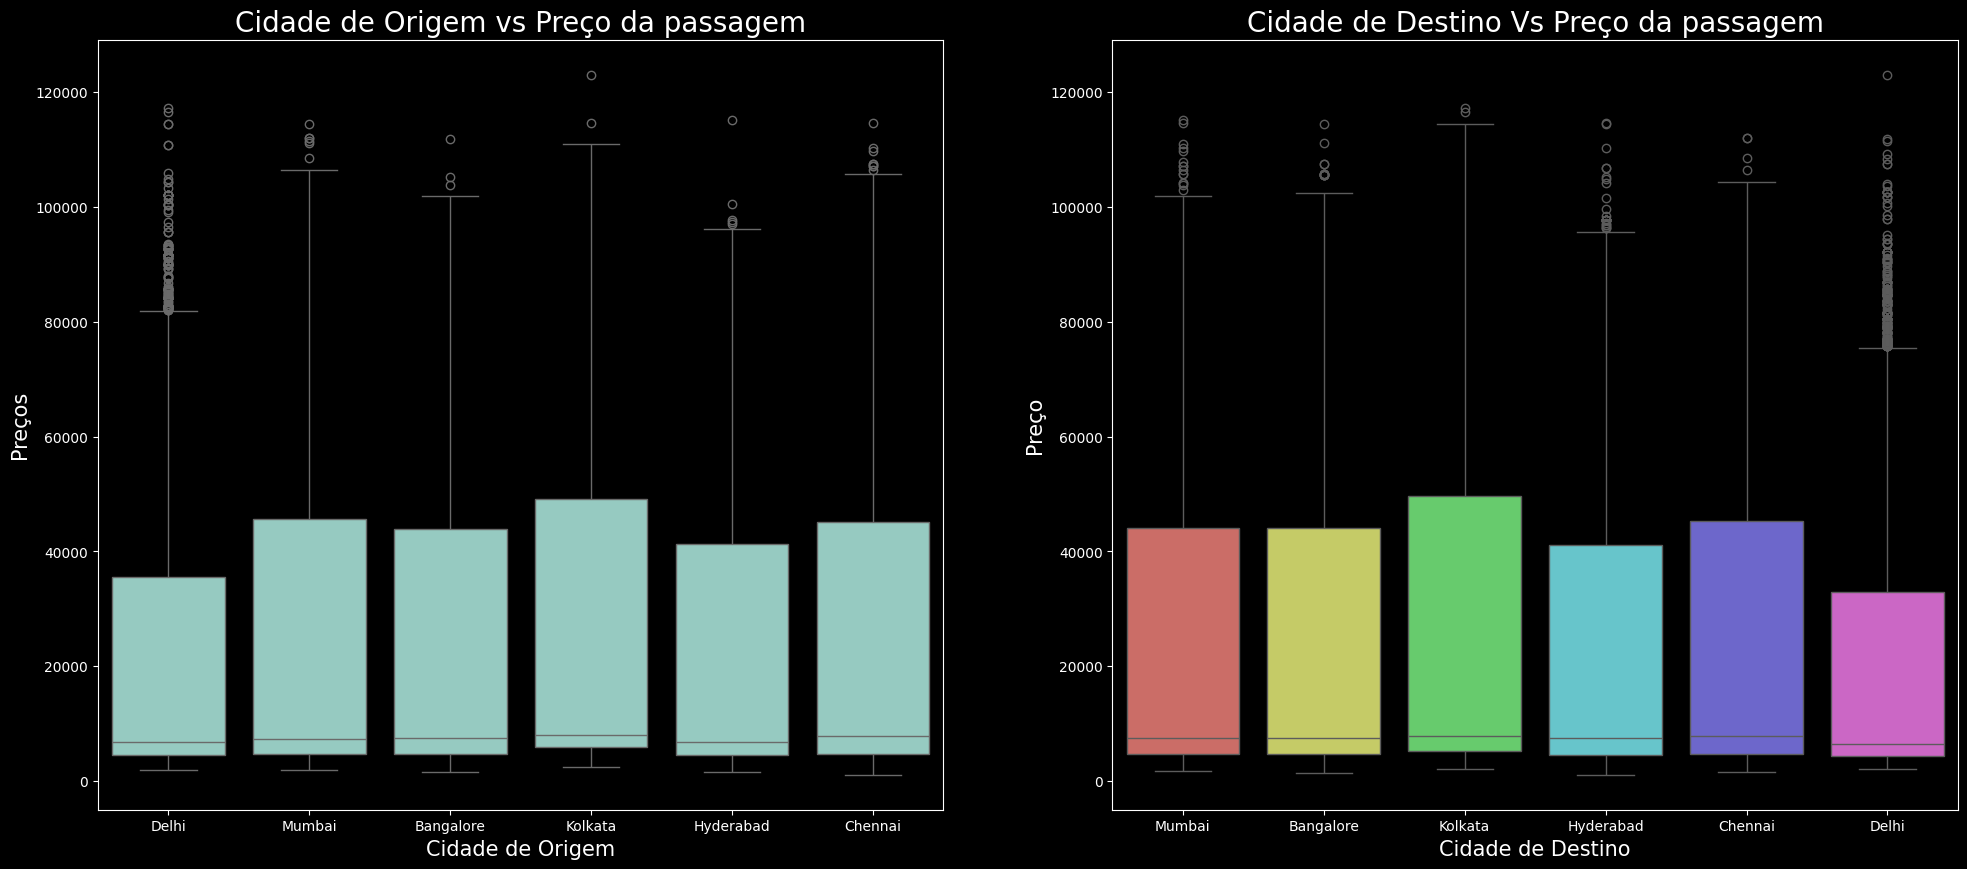

In [20]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='source_city',y='price',data=df_exploracao)
plt.title('Cidade de Origem vs Preço da passagem',fontsize=20)
plt.xlabel('Cidade de Origem',fontsize=15)
plt.ylabel('Preços',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='destination_city',y='price',data=df_exploracao,palette='hls')
plt.title('Cidade de Destino Vs Preço da passagem',fontsize=20)
plt.xlabel('Cidade de Destino',fontsize=15)
plt.ylabel('Preço',fontsize=15)
plt.show()

## Transformações promissoras

- Normalização/Escalonamento: Ajustar os valores numéricos para uma escala comum, geralmente entre 0 e 1, ou para uma distribuição normal. Isso é útil para algoritmos que são sensíveis à escala dos dados, como regressão linear e redes neurais.
- Codificação de Variáveis Categóricas: Converter variáveis categóricas em uma forma numérica que pode ser usada pelos algoritmos de aprendizado de máquina. Métodos comuns incluem One-Hot Encoding e Label Encoding.
- Transformações Logarítmicas: Aplicar uma transformação logarítmica para reduzir a assimetria dos dados

## Dados-extras

Exemplo de dados extras que podem ser úteis:
- Dados demográficos (idade, gênero, localização)
- Dados econômicos (renda, emprego)
- Dados temporais (sazonalidade, tendências)
- Dados de comportamento (histórico de compras, interações)

In [21]:
dados_extras = [
    'Idade',
    'Gênero',
    'Localização',
    'Renda',
    'Emprego',
    'Sazonalidade',
    'Tendências',
    'Histórico de Compras',
    'Interações'
]

# Exibir a lista de dados extras
print("Dados extras que podem ser úteis para a análise:")
for dado in dados_extras:
    print(f"- {dado}")

Dados extras que podem ser úteis para a análise:
- Idade
- Gênero
- Localização
- Renda
- Emprego
- Sazonalidade
- Tendências
- Histórico de Compras
- Interações


# Preparação

Os dados são transformados para se tornarem utilizáveis pelos modelos.

- Limpeza de dados: Lidamos com valores ausentes preenchendo-os com estratégias como a mediana, média ou moda. Também podemos remover outliers, especialmente se eles distorcem os resultados.
- Seleção de características: Excluímos atributos irrelevantes ou redundantes para simplificar o modelo e melhorar a eficiência.
- Feature engineering: Transformamos variáveis para melhorar seu impacto no modelo, como normalizar distribuições ou criar novas colunas a partir de dados existentes.
- Escalonamento: Normalizamos ou padronizamos variáveis numéricas para garantir que todas estejam na mesma escala, essencial para algoritmos que dependem de distâncias ou gradientes.

Para essa fase de preparação, temos a pergunta, **Oque mais influencia nos preços das passagens ?**

Pensando nisso, pensamos em uma forma de pré-processar os dados e levá-los para os modelos:

- Codificamos a variável stops para valores numéricos (0, 1, 2) e a variável class para valores numéricos (0, 1) 
- Criação de variáveis dummy:
    - Para as variáveis categóricas airline, source_city, destination_city, departure_time e arrival_time, foram criadas variáveis dummy. Isso significa que cada categoria dessas variáveis foi transformada em uma coluna binária (0 ou 1), indicando a presença ou ausência daquela categoria. Isso é necessário porque muitos algoritmos de aprendizado de máquina não podem trabalhar diretamente com dados categóricos.

In [22]:
def preprocessing(df_exploracao):
    # Transformar os dados categóricos em numéricos    
    df_exploracao["stops"] = df_exploracao["stops"].replace({'zero':0,'one':1,'two_or_more':2}).astype(int)
    df_exploracao["class"] = df_exploracao["class"].replace({'Economy':0,'Business':1}).astype(int)
    
    # Normalização dos dados
    dummies_variables = ["airline","source_city","destination_city","departure_time","arrival_time"]
    dummies = pd.get_dummies(df_exploracao[dummies_variables], drop_first= True)
    df_exploracao = pd.concat([df_exploracao,dummies],axis=1)
    
    # Drop das colunas originais
    df_exploracao = df_exploracao.drop(["flight","airline","source_city","destination_city","departure_time","arrival_time"],axis=1)
    
    return df_exploracao

In [23]:
df_preprocessado = preprocessing(df_exploracao)

Para visualizar a importância linear de cada variável no alvo, traçamos uma matriz de correlação.

<Axes: >

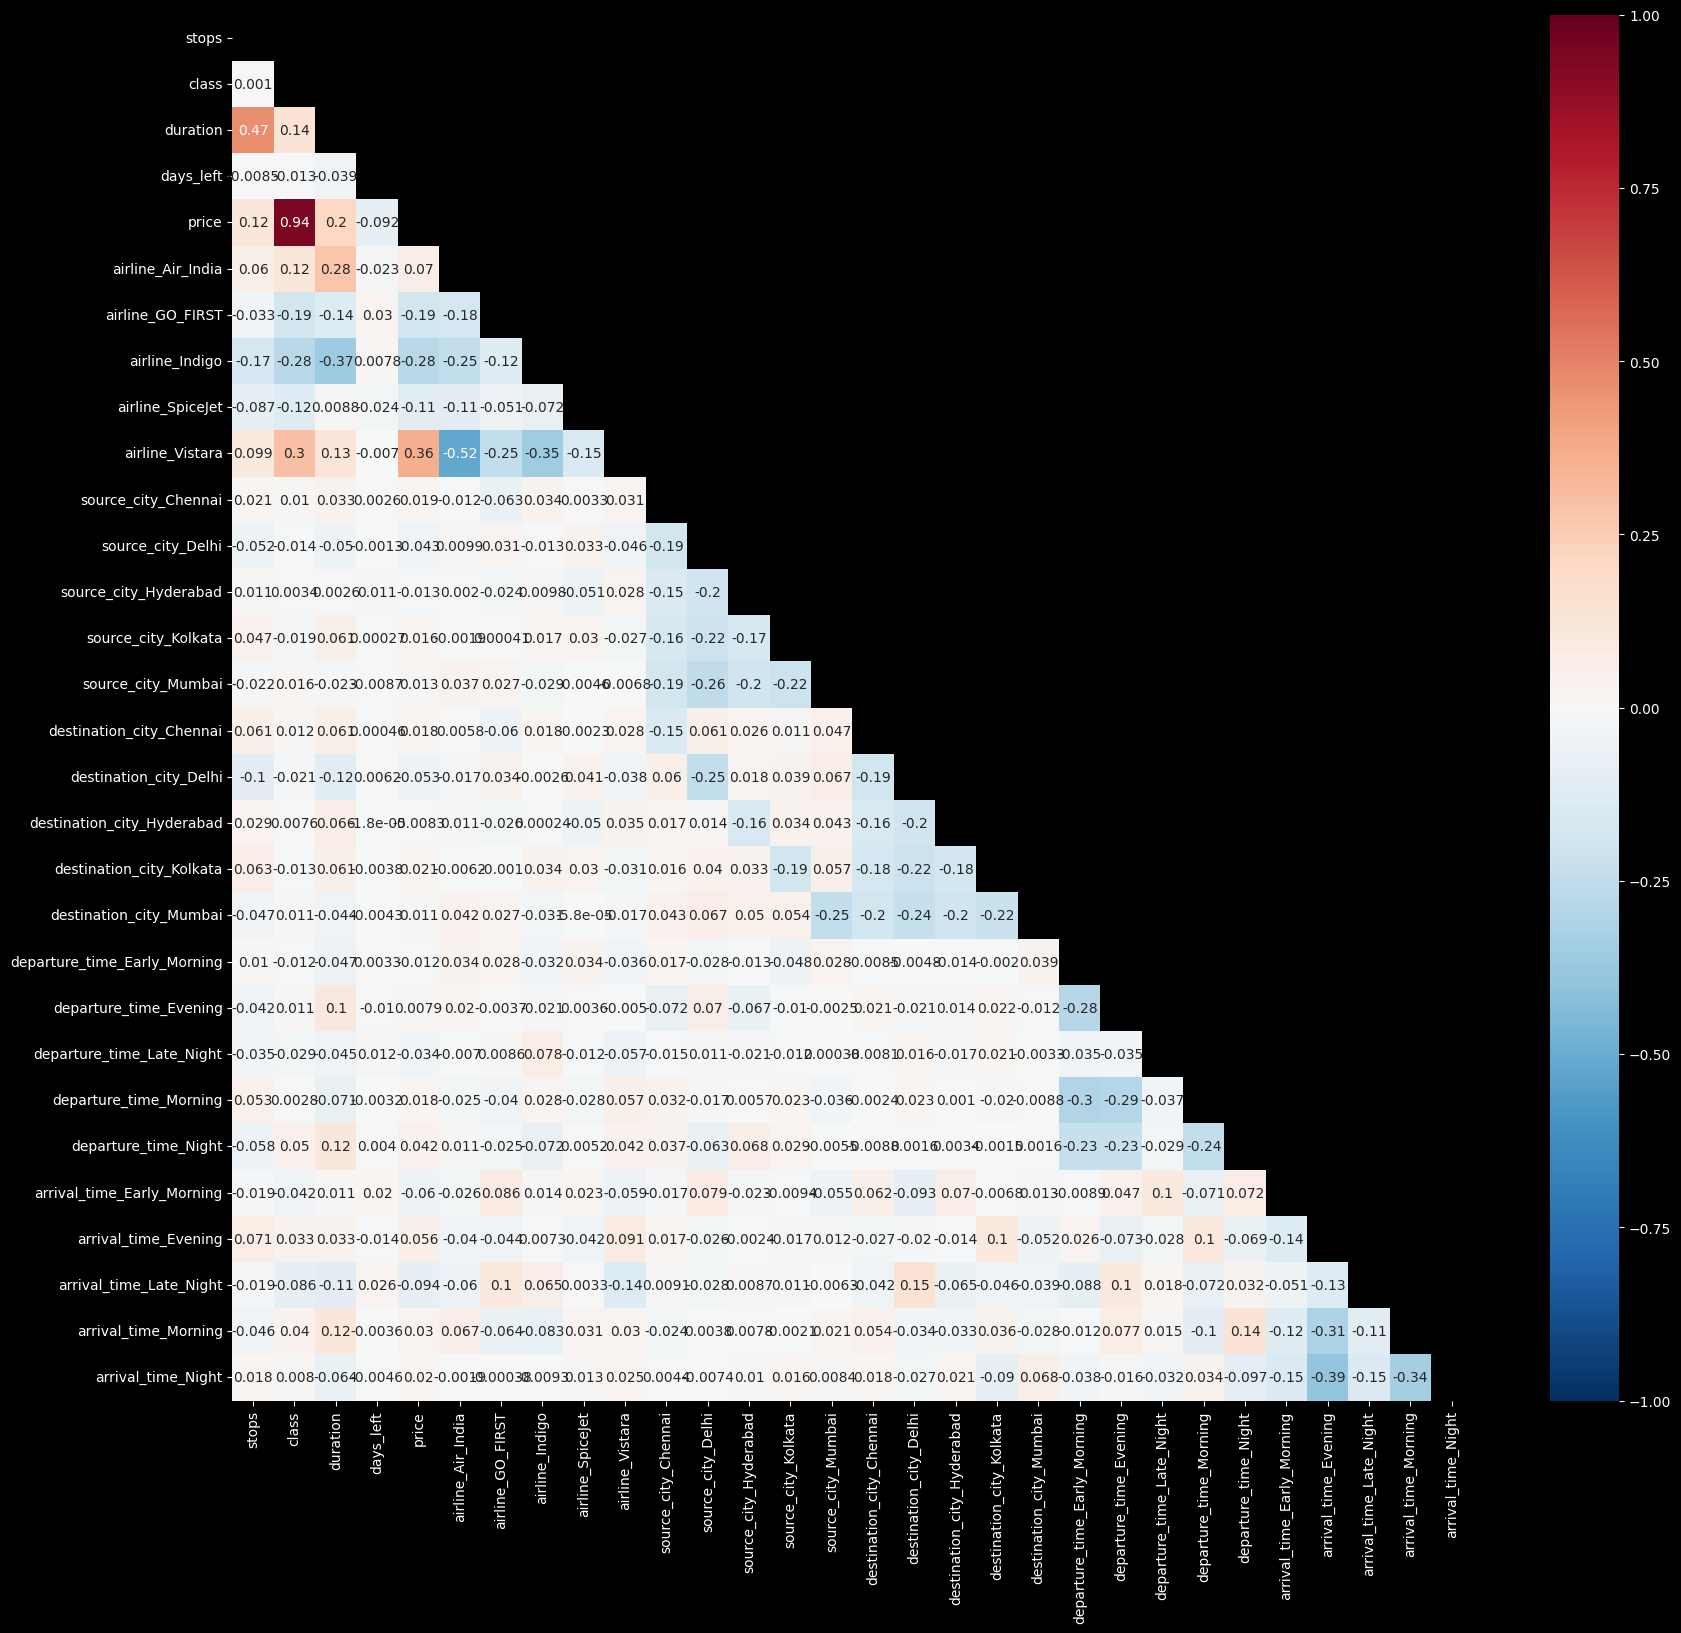

In [24]:
# Exibir as primeiras linhas do dataset preprocessado
mask = np.triu(np.ones_like(df_preprocessado.corr(), dtype=bool))

plt.figure(figsize = (20,18))
# Plotando a matriz de correlação
sns.heatmap(df_preprocessado.corr(), mask=mask, annot=True, vmin=-1.0, vmax=1.0, center=0, cmap='RdBu_r')

Porém, a correlação é uma boa métrica para relacionamento linear, mas não destaca os não lineares. Para isso, usamos informações mútuas, por isso usamos a Medição de Informação Mútua (MI) que ajuda a identificar quais variáveis independentes (features) têm maior relevância ou dependência com a variável dependente (target). Isso é útil para seleção de features, onde queremos escolher as variáveis mais informativas para o modelo. podendo ela capturar tanto relações lineares quanto não lineares entre as variáveis.

Para interpretá-la:

- A MI é sempre não negativa e varia de 0 a ∞.
- MI = 0: Indica que não há dependência entre a feature e o target. A feature não fornece nenhuma informação sobre o target.
- MI > 0: Indica que há alguma dependência entre a feature e o target. Quanto maior o valor, maior a dependência.

In [25]:
def make_mi_scores(X, y):
    # Fizemos uma cópia do DataFrame para evitar alterações indesejadas
    X = X.copy()
    # Transformar os dados categóricos em category e depois em numéricos com o factorize
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # Criamos uma lista booleana para identificar os atributos discretos
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    # Calculamos os scores de MI
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    # Transformamos os scores em uma série do pandas
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [26]:
# Fizemos uma cópia dos dados preprocessados e do target
X = df_preprocessado.copy()
y = X.pop("price")

mi_scores = make_mi_scores(X, y)

In [27]:
print(mi_scores.sort_values(ascending=False))

duration                        2.415277
class                           0.618093
airline_Vistara                 0.517385
days_left                       0.477406
source_city_Delhi               0.430462
source_city_Mumbai              0.428634
airline_Air_India               0.403297
stops                           0.392738
destination_city_Delhi          0.387216
destination_city_Mumbai         0.382443
source_city_Kolkata             0.360909
source_city_Hyderabad           0.346552
destination_city_Kolkata        0.339796
source_city_Chennai             0.325926
destination_city_Hyderabad      0.318186
destination_city_Chennai        0.302343
airline_Indigo                  0.286906
airline_GO_FIRST                0.202483
arrival_time_Evening            0.127975
arrival_time_Night              0.106256
departure_time_Evening          0.104635
arrival_time_Morning            0.102338
departure_time_Morning          0.092502
departure_time_Early_Morning    0.089224
airline_SpiceJet

**Features Mais Informativas:**

- **duration (2.415277):** A duração do voo é a feature mais informativa, indicando que tem a maior dependência com o preço das passagens.
- **class (0.618093):** A classe do assento (Economy ou Business) também é altamente informativa.
- **airline_Vistara (0.517385):** A companhia aérea Vistara tem uma influência significativa no preço das passagens.
- **days_left (0.477406):** O número de dias restantes até o voo também é uma feature importante.
- **source_city_Delhi (0.430462) e source_city_Mumbai (0.428634):** As cidades de origem Delhi e Mumbai são relevantes para a determinação do preço.

**Features Moderadamente Informativas:**

- **airline_Air_India (0.403297):** A companhia aérea Air India tem uma influência moderada.
- **stops (0.392738):** O número de paradas durante o voo também é relevante.
- **destination_city_Delhi (0.387216) e destination_city_Mumbai (0.382443):** As cidades de destino Delhi e Mumbai têm uma influência moderada.

**Features Menos Informativas:**

- **departure_time_Late_Night (0.013410):** O horário de partida tarde da noite é a feature menos informativa.
- **arrival_time_Late_Night (0.070387):** O horário de chegada tarde da noite também tem pouca influência.

In [28]:
# Selecionar as top 10 features mais informativas
top_10_features = mi_scores.head(10)
print("Top 10 features mais informativas:\n", top_10_features)

# Filtrar o DataFrame original para incluir apenas essas features
selected_features = top_10_features.index
X_selected = X[selected_features]

Top 10 features mais informativas:
 duration                   2.415277
class                      0.618093
airline_Vistara            0.517385
days_left                  0.477406
source_city_Delhi          0.430462
source_city_Mumbai         0.428634
airline_Air_India          0.403297
stops                      0.392738
destination_city_Delhi     0.387216
destination_city_Mumbai    0.382443
Name: MI Scores, dtype: float64
